<a href="https://colab.research.google.com/github/adamlutzz/DS-Unit-2-Applied-Modeling/blob/master/Epilepsy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TO-DOs


*   Look for leakage (unbalanced classes?)
*   Look for a story to tell about the data
*   Run PCA and refine model
*   Figure out how to engineer features if needed
*   Decide what graphs best explain the narrative



**Attribute Information:**

The original dataset from the reference consists of 5 different folders, each with 100 files, with each file representing a single subject/person. Each file is a recording of brain activity for 23.6 seconds. The corresponding time-series is sampled into 4097 data points. Each data point is the value of the EEG recording at a different point in time. So we have total 500 individuals with each has 4097 data points for 23.5 seconds.

We divided and shuffled every 4097 data points into 23 chunks, each chunk contains 178 data points for 1 second, and each data point is the value of the EEG recording at a different point in time. So now we have 23 x 500 = 11500 pieces of information(row), each information contains 178 data points for 1 second(column), the last column represents the label y {1,2,3,4,5}.

The response variable is y in column 179, the Explanatory variables X1, X2, ..., X178

y contains the category of the 178-dimensional input vector. Specifically y in {1, 2, 3, 4, 5}:

5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open

4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed

3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area

2 - They recorder the EEG from the area where the tumor was located

1 - Recording of seizure activity

All subjects falling in classes 2, 3, 4, and 5 are subjects who did not have epileptic seizure. Only subjects in class 1 have epileptic seizure. Our motivation for creating this version of the data was to simplify access to the data via the creation of a .csv version of it. Although there are 5 classes most authors have done binary classification, namely class 1 (Epileptic seizure) against the rest.

### Setup

In [1]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:

    # Install required python packages
    !pip install -r 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/requirements.txt'

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 112kB 9.2MB/s 
     |████████████████████████████████| 133kB 40.8MB/s 
     |████████████████████████████████| 57.7MB 26.2MB/s 
     |████████████████████████████████| 245kB 35.8MB/s 
     |████████████████████████████████| 614kB 30.0MB/s 
     |████████████████████████████████| 235kB 37.7MB/s 
     |████████████████████████████████| 307kB 30.8MB/s 
     |████████████████████████████████| 215kB 27.0MB/s 
     |████████████████████████████████| 51kB 11.5MB/s 
     |████████████████████████████████| 51kB 18.1MB/s 
     |████████████████████████████████| 737kB 33.9MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145035 sha256=23321a56cf26de9ea698c58316777b55ad50541c27d960d2b78093ffc067e901
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for pdpbox: filename=PDPbox-0.2.0-

### Read in Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas_profiling

link ='https://archive.ics.uci.edu/ml/machine-learning-databases/00388/data.csv'

df = pd.read_csv(link)

print(df.shape)
df.head()

(11500, 180)


Unnamed: 0   X1   X2   X3   X4   X5  ...  X174  X175  X176  X177  X178  y
0  X21.V1.791  135  190  229  223  192  ...  -103  -127  -116   -83   -51  4
1  X15.V1.924  386  382  356  331  320  ...   157   156   154   143   129  1
2     X8.V1.1  -32  -39  -47  -37  -32  ...   -12   -30   -35   -35   -36  5
3   X16.V1.60 -105 -101  -96  -92  -89  ...   -85   -77   -72   -69   -65  5
4   X20.V1.54   -9  -65  -98 -102  -78  ...   -41   -65   -83   -89   -73  5

[5 rows x 180 columns]

In [0]:
# set target
target = 'y'

### Profile Report

In [4]:
# visualize data with Pandas Profiling
df.profile_report()

### Pre-Processing

In [5]:
# See distribution of target
df['y'].value_counts(normalize=True)

5    0.2
4    0.2
3    0.2
2    0.2
1    0.2
Name: y, dtype: float64

In [6]:
# I want to see the actual values
df['y'].value_counts()

5    2300
4    2300
3    2300
2    2300
1    2300
Name: y, dtype: int64

In [7]:
# create target feature with binary condition for seizure
df['seizure'] = df['y'] == 1

# check work
df.head()

Unnamed_0   X1   X2   X3   X4   X5  ...  X175  X176  X177  X178  y  seizure
0  X21.V1.791  135  190  229  223  192  ...  -127  -116   -83   -51  4    False
1  X15.V1.924  386  382  356  331  320  ...   156   154   143   129  1     True
2     X8.V1.1  -32  -39  -47  -37  -32  ...   -30   -35   -35   -36  5    False
3   X16.V1.60 -105 -101  -96  -92  -89  ...   -77   -72   -69   -65  5    False
4   X20.V1.54   -9  -65  -98 -102  -78  ...   -65   -83   -89   -73  5    False

[5 rows x 181 columns]

In [8]:
# what is the baseline?
df['seizure'].value_counts(normalize=True)

False    0.8
True     0.2
Name: seizure, dtype: float64

In [18]:
# fix column 1 header
df.rename(columns={'Unnamed_0':'id'}, inplace=True )
df.head()

id   X1   X2   X3   X4   X5  ...  X175  X176  X177  X178  y  seizure
0  X21.V1.791  135  190  229  223  192  ...  -127  -116   -83   -51  4    False
1  X15.V1.924  386  382  356  331  320  ...   156   154   143   129  1     True
2     X8.V1.1  -32  -39  -47  -37  -32  ...   -30   -35   -35   -36  5    False
3   X16.V1.60 -105 -101  -96  -92  -89  ...   -77   -72   -69   -65  5    False
4   X20.V1.54   -9  -65  -98 -102  -78  ...   -65   -83   -89   -73  5    False

[5 rows x 181 columns]

In [0]:
def wrangle(df):
    
    # prevent copy warning
    df = df.copy()

    # Drop features with unsable variance or high missing values
    unusable_variance = ['id', 'y']
    df = df.drop(columns=unusable_variance)

    return df

df = wrangle(df)

In [21]:
from sklearn.model_selection import train_test_split

# 80/20 train test split
train, test = train_test_split(df, test_size=.20, stratify=df['seizure'],
                               random_state=11)
# confirm size
train.shape, test.shape

((9200, 179), (2300, 179))

In [22]:
# validation set
train, val = train_test_split(train, test_size=.20, stratify=train['seizure'],
                              random_state=11)
# confirm size
train.shape, val.shape

((7360, 179), (1840, 179))

In [0]:
# create target
target = 'seizure'

# create X_features matrix and y_target vector for train
X_train = train.drop(columns=target)
y_train = train[target]

# create X_features matrix and y_target vector for val
X_val = val.drop(columns=target)
y_val = val[target]

# create X_features matrix and y_target vector for test
X_test = test.drop(columns=target)
y_test = test[target]

In [0]:
# imports for pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

# Make pipeline!
RF = make_pipeline( 
    RandomForestClassifier(random_state=11, n_jobs=-1)
)

In [25]:
# Fit on train, score on val
RF.fit(X_train, y_train)
y_pred = RF.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.9657608695652173


### ROC AUC

In [0]:
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
plt.style.use('dark_background')

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

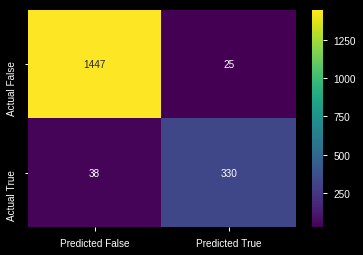

In [37]:
plot_confusion_matrix(y_val, y_pred);

So as of right now it looks like I have a pretty good True positive and false positive rate<br/>
This could easily be a result of my imbalanced classes

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.98      0.98      1472
        True       0.93      0.90      0.91       368

    accuracy                           0.97      1840
   macro avg       0.95      0.94      0.95      1840
weighted avg       0.97      0.97      0.97      1840



In [29]:
from sklearn.metrics import roc_auc_score

y_pred_proba = np.full_like(y_val, fill_value=1.00)
roc_auc_score(y_val, y_pred_proba)

0.5

In [30]:
y_val.value_counts()

False    1472
True      368
Name: seizure, dtype: int64

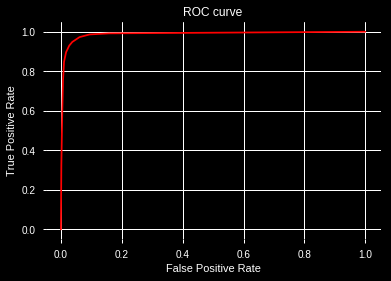

In [40]:
# plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val==True, y_pred_proba)
plt.plot(fpr, tpr, color='r')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [94]:
# ROC Score
y_pred_proba = RF.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.9876222087665406

In [44]:
from ipywidgets import interact, fixed
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    """
    For binary classification problems. 
    y_pred_proba : predicted probability of class 1
    """
    
    # Apply threshold to predicted probabilities
    # to get discrete predictions
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1
    
    # Plot distribution of predicted probabilities
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.title('Distribution of predicted probabilities')
    plt.show()

    # Calculate true positive rate and false positive rate
    true_positives = (y_pred==y_true) & (y_pred==class_1)
    false_positives = (y_pred!=y_true) & (y_pred==class_1)
    actual_positives = (y_true==class_1)
    actual_negatives = (y_true==class_0)
    true_positive_rate = true_positives.sum() / actual_positives.sum()
    false_positive_rate = false_positives.sum() / actual_negatives.sum()
    print('False Positive Rate', false_positive_rate)
    print('True Positive Rate', true_positive_rate)
    
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr, color='r')
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Plot point on ROC curve for the current threshold
    plt.scatter(false_positive_rate, true_positive_rate)
    plt.show()
    
    # Show ROC AUC score
    print('Area under the Receiver Operating Characteristic curve:', 
          roc_auc_score(y_true, y_pred_proba))
    
    # Show confusion matrix & classification report
    plot_confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))

interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0,1,0.05));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

### Permutation Importances

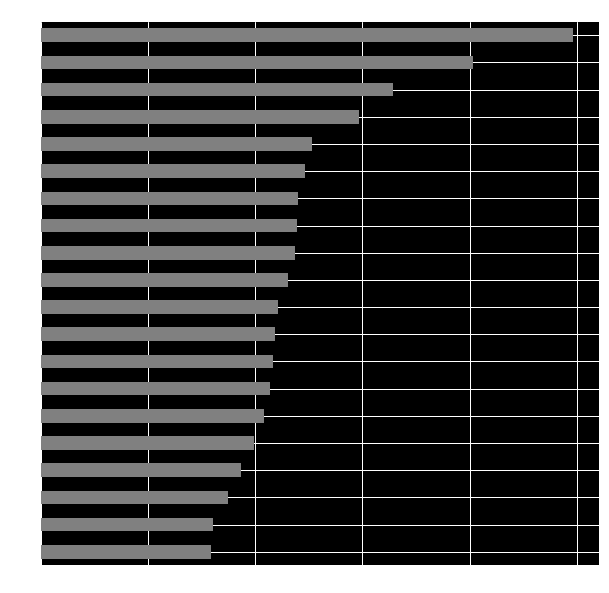

In [43]:
# Get feature importances
rand_f = RF.named_steps['randomforestclassifier']
importances = pd.Series(rand_f.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [45]:
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [48]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=2,
    random_state=42
)

permuter.fit(X_val, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Using TensorFlow backend.


### Partial Dependence Plots

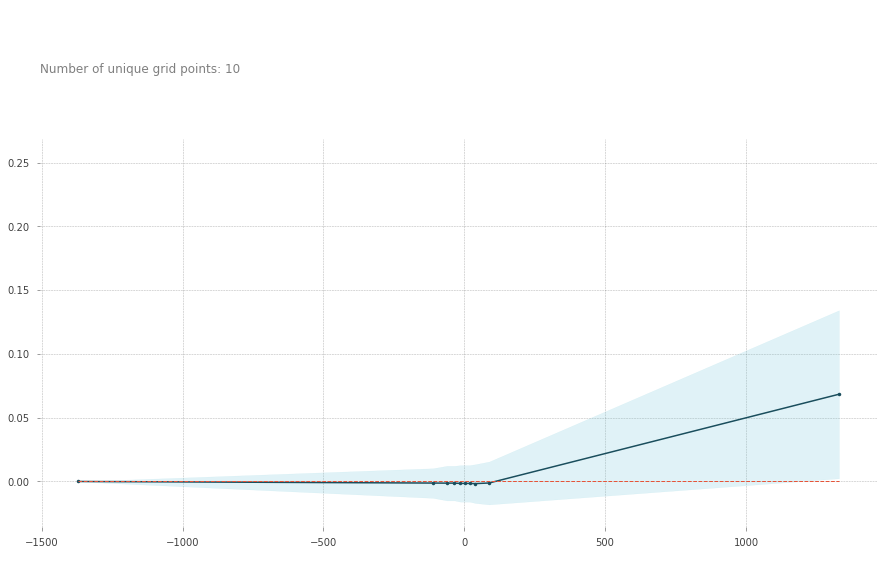

In [50]:
# single feature partial dependency plot
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'X162'

isolated = pdp_isolate(
    model = RF,
    dataset = X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

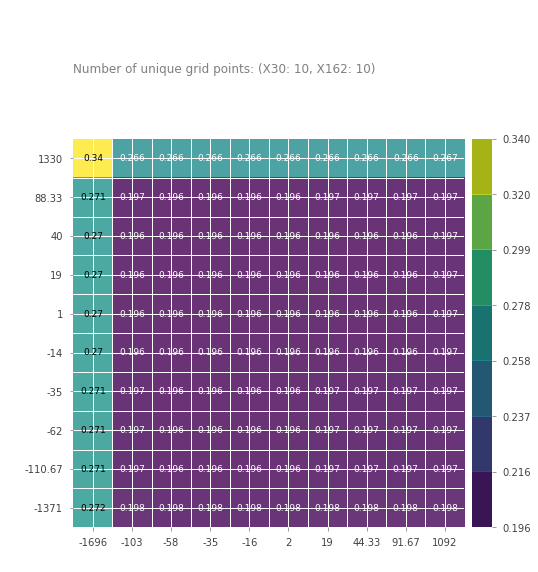

In [60]:
# multifeature partial dependency plots
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['X30', 'X162']

interaction = pdp_interact(
  model=RF,
  dataset=X_val,
  model_features=X_val.columns,
  features=features 
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

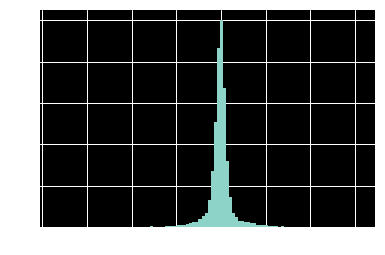

In [55]:
# These are interesting values Lets look at them closer
df['X162'].hist(bins=100)

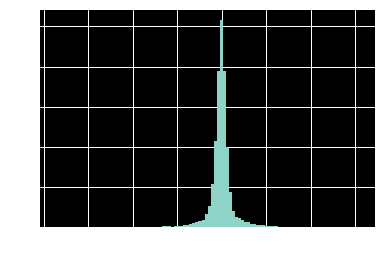

In [56]:
# These are interesting values Lets look at them closer
df['X30'].hist(bins=100)

### PCA

In [0]:
# drop target from new train
pca_train = train.drop(columns=target)


 Eigenvectors: 
 [[ 0.00308616  0.00737778  0.01131886  0.01450031  0.01784524  0.02194525
   0.02579083  0.02957254  0.03081581  0.02873948  0.02383309  0.01732457
   0.01114076  0.00646656  0.00015381 -0.01035041 -0.02645823 -0.04362162
  -0.05930733 -0.07122249 -0.07941335 -0.08307048 -0.08296506 -0.08108132
  -0.07853465 -0.07650182 -0.07434136 -0.06860385 -0.05957897 -0.04601966
  -0.03054272 -0.01428775  0.00373866  0.02238909  0.04238377  0.06272277
   0.08001628  0.09208307  0.1005527   0.10534547  0.10813563  0.10846213
   0.10675292  0.10340818  0.09820235  0.08959321  0.07624229  0.05893717
   0.03687174  0.01199182 -0.01634843 -0.04549629 -0.0693788  -0.08771162
  -0.09787109 -0.10487268 -0.1090255  -0.11143408 -0.11246687 -0.11126313
  -0.10425039 -0.08784753 -0.06090778 -0.03046144  0.00069475  0.02841726
   0.05178376  0.07167928  0.09017658  0.10650767  0.11904264  0.12643759
   0.12550339  0.11704078  0.09996212  0.07714562  0.04983553  0.0215116
  -0.00622938 -0.0309

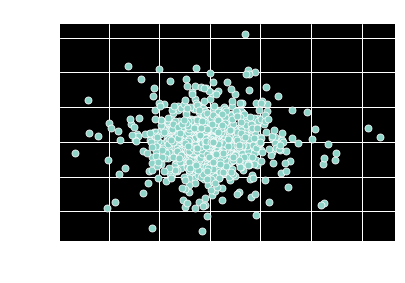

In [84]:
# run PCA on dataset
from sklearn.preprocessing import StandardScaler
from numpy import array
from sklearn.decomposition import PCA
import seaborn as sns

# create the PCA instance
pca = PCA(3)

# fit on data
pca.fit(X_train)

# access values and vectors
print("\n Eigenvectors: \n", pca.components_)
print("\n Eigenvalues: \n", pca.explained_variance_)

# transform data
B = pca.transform(X_train)

# plot data
pca_X_train = pd.DataFrame(B)
pca_X_train = pca_X_train.rename(columns={0:'x', 1:'y', 2:'z'})

pca_df.head()
sns.scatterplot(x='x', y='y', data=pca_X_train)
plt.title('PCA on EEG Dataset', fontsize=15, color='w')
plt.show()


 Eigenvectors: 
 [[-0.0095592  -0.02236748 -0.02630119 -0.02259106 -0.01233494 -0.00021495
   0.01246343  0.02297923  0.02953684  0.03219587  0.03068249  0.02417657
   0.01443483  0.00375423 -0.00591907 -0.01247379 -0.01470719 -0.01295437
  -0.01172708 -0.01367034 -0.02073662 -0.03047159 -0.03809776 -0.04601374
  -0.04819219 -0.04724884 -0.04048276 -0.03400783 -0.03166056 -0.03210042
  -0.03059077 -0.02213982 -0.00795081  0.00316806  0.01473124  0.02246772
   0.03081113  0.03381798  0.03315656  0.02492343  0.01253537 -0.00613108
  -0.02446503 -0.04157331 -0.05090311 -0.05118333 -0.04440802 -0.03811873
  -0.03146718 -0.02791936 -0.0261188  -0.0211825  -0.01658171 -0.01042012
  -0.00297523  0.00552587  0.01732014  0.02596913  0.02952996  0.03135198
   0.0385187   0.05476543  0.06933092  0.08020816  0.08108334  0.07875896
   0.07681777  0.07218936  0.06457478  0.05643214  0.04625708  0.03775794
   0.02950261  0.01905842  0.00885112 -0.0027553  -0.01640601 -0.02958283
  -0.04344822 -0.055

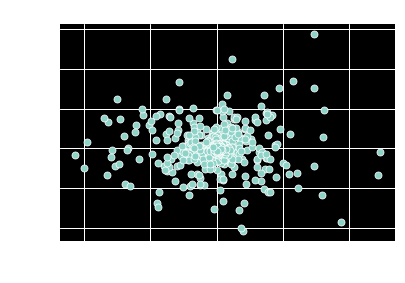

In [90]:
# run PCA on dataset
from sklearn.preprocessing import StandardScaler
from numpy import array
from sklearn.decomposition import PCA
import seaborn as sns

# create the PCA instance
pca = PCA(3)

# fit on data
pca.fit(X_val)

# access values and vectors
print("\n Eigenvectors: \n", pca.components_)
print("\n Eigenvalues: \n", pca.explained_variance_)

# transform data
B = pca.transform(X_val)

# plot data
pca_X_val = pd.DataFrame(B)
pca_X_val = pca_X_val.rename(columns={0:'x', 1:'y', 2:'z'})

pca_df.head()
sns.scatterplot(x='x', y='y', data=pca_X_val)
plt.title('PCA on EEG Dataset', fontsize=15, color='w')
plt.show()

In [91]:
# confirm shape
pca_X_train.shape, pca_X_val.shape

((7360, 3), (1840, 3))

In [99]:
# Make pipeline!
pca_RF = make_pipeline( 
    RandomForestClassifier(random_state=11, n_jobs=-1, class_weight='balanced_subsample')
)
# Fit on train, score on val
pca_RF.fit(pca_X_train, y_train)
y_pred = pca_RF.predict(pca_X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.9418478260869565


Based on these findings I am wondering if PCA really made my model weaker or if it is not overfit.

In [100]:
# ROC Score
y_pred_proba = pca_RF.predict_proba(pca_X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.9608378130907371